# A/B testing project

<b> Terms of Reference: </b>
* Test name: recommender_system_test;
* Groups: A (control), B (new payment funnel);
* Launch Date: 2020-12-07;
* Date of stopping the recruitment of new users: 2020-12-21;
* Stop date: 2021-01-04;
* Audience: 15% of new users from the EU region;
* Purpose of the test: testing of changes related to the implementation of an improved recommendation system;
* Expected number of test participants: 6000.
* Expected effect: in 14 days from the moment of registration in the system, users will show an improvement in each metric by at least 10%:
* conversions to viewing product cards — the product_page event
* basket views — product_cart
    * purchases — purchase.
      
<b> Data: </b>
- ab_project_marketing_events.csv — calendar of marketing events for 2020;
- final_ab_new_users.csv — all users who registered in the online store in the period from December 7 to December 21, 2020;
- final_ab_events.csv — all events of new users in the period from December 7, 2020 to January 4, 2021;
- final_ab_participants.csv — table of test participants.

<b> Research objectives: </b>
- Assessment of the correctness of the test;
- Analysis of test results.

## Data Preparation and Exploration

In [201]:
import pandas as pd
import numpy as np
import math as mth
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st
from plotly import graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [202]:
marketing_events = pd.read_csv('/Users/vintera/Git/my_projects/dataset/project_12/ab_project_marketing_events.csv')
users = pd.read_csv('/Users/vintera/Git/my_projects/dataset/project_12/final_ab_new_users.csv')
events = pd.read_csv('/Users/vintera/Git/my_projects/dataset/project_12/final_ab_events.csv')
participants = pd.read_csv('/Users/vintera/Git/my_projects/dataset/project_12/final_ab_participants.csv')

In [203]:
marketing_events
marketing_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [204]:
users.sample(5)
users.info()

,user_id,first_date,region,device
49747,3DC81C2669E3EEF2,2020-12-19,EU,PC
35660,7C908A054B623C5A,2020-12-10,EU,Android
49819,25AFE52E8B033172,2020-12-19,N.America,Android
51579,3D244BFFB35D8CFC,2020-12-19,N.America,Android
3412,A13077E1AAA391DD,2020-12-07,EU,Android


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [205]:
events.sample(5)
events.info()

,user_id,event_dt,event_name,details
392962,73CF1355CC711498,2020-12-22 10:43:09,login,NaN
138244,E58765D4936EF8FD,2020-12-10 17:55:29,product_page,NaN
158269,85AF3968F5535E39,2020-12-14 06:01:45,product_page,NaN
148870,FEC9089D2A4D1BA1,2020-12-13 00:51:40,product_page,NaN
32128,DBD606A00777E27D,2020-12-19 10:32:36,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [206]:
participants.sample(5)
participants.info()

,user_id,group,ab_test
18172,8F3559A16ADC8D54,A,interface_eu_test
14206,6B280A59E356C47B,A,interface_eu_test
11261,9949A6B619681862,A,interface_eu_test
15375,546BB65F575BA3CB,A,interface_eu_test
6382,2073AB360C197095,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


### Summary
During the initial acquaintance with the data, it was found that the dates are specified in the object format, which will need to be corrected in the data preprocessing.

## Data preprocessing and research

In [207]:
# Convert columns with dates in all dataframes to the appropriate format
marketing_events['start_dt'] = marketing_events['start_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
marketing_events['finish_dt'] = marketing_events['finish_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
users['first_date'] = users['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
events['event_dt'] = events['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# In the event table, add a new column containing dates
events['date'] = events['event_dt'].astype('datetime64[D]')

In [208]:
# We will check for complete duplicates
users.duplicated().sum()
events.duplicated().sum()
participants.duplicated().sum()

0

0

0

### Comment
There are no duplicates in the data

In [209]:
events.query('event_name != "purchase"').count()
events.query('event_name == "purchase"').count()

user_id       377577
event_dt      377577
event_name    377577
details            0
date          377577
dtype: int64

user_id       62740
event_dt      62740
event_name    62740
details       62740
date          62740
dtype: int64

### Comment
The omissions are available exclusively in the details column of the event table, since it contains information only for purchase events. We will not change anything.

### Preparation of data in accordance with the TOR

In [210]:
users.first_date.min()
users.first_date.max()

Timestamp('2020-12-07 00:00:00')

Timestamp('2020-12-23 00:00:00')

#### Comment
New users are recruited until December 23, 2020. We will leave the data on users typed up to and including December 21, in accordance with the requirements of the TOR.

In [211]:
spec_users = users.query('first_date <= "2020-12-21"')
spec_users.describe()

,user_id,first_date,region,device
count,56470,56470,56470,56470
unique,56470,15,4,4
top,D72A72121175D8BE,2020-12-21 00:00:00,EU,Android
freq,1,6290,42340,25161
first,NaN,2020-12-07 00:00:00,NaN,NaN
last,NaN,2020-12-21 00:00:00,NaN,NaN


#### Comment
We have 56470 new users left, recruited before December 21

In [212]:
events.event_dt.describe()

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

#### Comment
Unfortunately, event data was collected only until 2020-12-30 23:36:33, and according to the technical specification, the test stop date is 2021-01-04. We will work with the available data.

In [213]:
spec_participants = participants.query('ab_test == "recommender_system_test"')
len(spec_participants)

6701

#### Comment
6701 users participated in the "recommender_system_test". Let's check if the users were repeated in two groups.

In [214]:
spec_participants.group.value_counts()

A    3824
B    2877
Name: group, dtype: int64

In [215]:
group_a = spec_participants.query('group == "A"')
group_b = spec_participants.query('group == "B"')

In [216]:
group_a.query('user_id in @group_b')['user_id'].count()
group_b.query('user_id in @group_a')['user_id'].count()

0

0

#### Comment
There are no duplicate users in Groups A and B.

In [217]:
# Connect the resulting tables. First, we will attach data from the users table to the id from the participants table,
# then we will attach data on completed events from the events table to the resulting table, also by id.
spec_df = spec_participants.merge(spec_users, how='inner', on='user_id').merge(events, how='left', on='user_id')

In [218]:
spec_df.user_id.nunique()
spec_df.groupby('group').agg({'user_id' : 'nunique'})

6701

,user_id
group,
A,3824
B,2877


#### Comment
Unfortunately, in the resulting table, after transformations in accordance with the requirements of the TOR, only 3675 unique users remained, which is significantly less than the expected 6000. We will inform the customer about this problem and continue the research with the available data.

In [219]:
users_regions = spec_df.groupby('region').agg({'user_id': 'nunique'}).reset_index()
all_users_regions = users.groupby('region').agg({'user_id': 'nunique'}).reset_index()
users_regions = all_users_regions.merge(users_regions, how='inner', on='region')
users_regions['ratio'] = users_regions['user_id_y'] / users_regions['user_id_x']
users_regions = users_regions.rename(columns={"region": "Регион", 
                              "user_id_x": "Всего", 
                              "user_id_y": "Тестовая группа", 
                              "ratio": "Соотношение"})
display(users_regions.style.format({'Соотношение':"{0:.1%}"}))

,Регион,Всего,Тестовая группа,Соотношение
0,APAC,3153,72,2.3%
1,CIS,3155,55,1.7%
2,EU,46270,6351,13.7%
3,N.America,9155,223,2.4%


#### Comment
Regarding the requirement of 15% of new users from the EU, everything is not very good either. Almost 95% of users are from the mentioned region and it is not worth reducing the audience to a percentage of TK, since there will be no data left for research at all. We will also mention this circumstance in the report to the customer.

In [220]:
recomender_participants = participants.query('ab_test == "recommender_system_test"')
recomender_user_list = participants.query('ab_test == "recommender_system_test"')['user_id']
interface_participants = participants.query('ab_test == "interface_eu_test"')
interface_user_list = participants.query('ab_test == "interface_eu_test"')['user_id']

In [221]:
recomender_participants.query('user_id in @interface_user_list')['user_id'].count()
interface_participants.query('user_id in @recomender_user_list')['user_id'].count()

1602

1602

#### Comment
1602 users participated simultaneously in recommender_system_test and interface_eu_test. Participation in several places at the same time affects the adequacy of the test negatively. We will also inform the customer about this.

### Summary

When bringing the data into compliance with the requirements of the TOR, most of the data was lost. The errors of the test were revealed (participation in several tests simultaneously by 1602 users). It is necessary to prepare an appropriate report on the identified circumstances and send it to the research customer.

## Exploratory Data Analysis

### Conversion in the funnel at different stages

In [222]:
# Group by events
all_events = spec_df.groupby('event_name').agg({'user_id' : 'count'}).sort_values(
    by = 'user_id', ascending = False).reset_index()
all_events

,event_name,user_id
0,login,11190
1,product_page,6930
2,purchase,3331
3,product_cart,3247


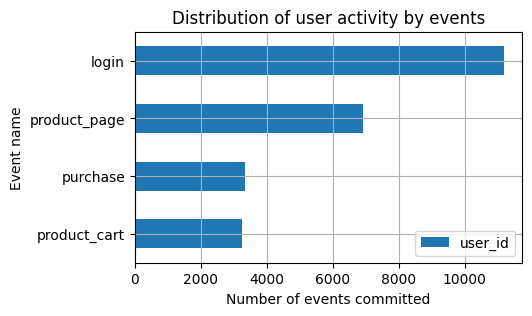

In [223]:
all_events.sort_values(by='user_id').plot(kind='barh', x='event_name', y='user_id', grid=True, figsize=(5,3))
plt.title('Distribution of user activity by events')
plt.xlabel('Number of events committed')
plt.ylabel('Event name');

#### Comment
There are 4 types of events in the log. Starting from the most popular, it is:
 - login (Authorization);
 - product_page (Product page);
 - purchase;
 - product_cart (Grocery basket).
 
Oddly enough, there are no "Purchase" events, there are more "Grocery basket" events. It can be assumed that users have the opportunity to make a quick purchase without going to the shopping cart page.

#### Funnel of all events

In [224]:
# Group the number of all events by dates
users_funnel = spec_df.pivot_table(
    index='date', 
    columns='event_name', 
    values='user_id',
    aggfunc='count')

In [225]:
# Build a graph of the funnel of events, where the values, broken down by dates, are summarized
fig = go.Figure(go.Funnel(
    y = ["Authorization",
         "Product Page", 
         "Shopping cart", 
         "Purchase"],
    x = [users_funnel.login.sum(), 
         users_funnel.product_page.sum(), 
         users_funnel.product_cart.sum(), 
         users_funnel.purchase.sum()]
    ))
fig.show()

##### Summary
61.9% of users reach the product page from authorization when the event "grocery basket" or "purchase" is made by 29-30% of authorized users.

#### Funnel of unique users

In [226]:
# Create a summary table where the values will be the first dates of events committed by users
uniq_users = spec_df.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='event_dt',
    aggfunc='min').reset_index()

In [227]:
# Build a funnel and count the users who have at least once committed this or that event
fig = go.Figure(go.Funnel(
    y = ["Authorization",
         "Product Page", 
         "Shopping cart", 
         "Purchase"],
    x = [uniq_users.login.count(), 
         uniq_users.product_page.count(), 
         uniq_users.product_cart.count(), 
         uniq_users.purchase.count()]
    ))
fig.show()

##### Summary
Examining the funnel of events by unique users, the picture in percentage ratio is approximately the same as it was in the first funnel.

### Distribution of the number of events per user in the samples

In [228]:
# Divide the events by selections
event_A = spec_df.query('group == "A"').groupby('event_name').agg({'user_id': 'count'}).reset_index()
event_B = spec_df.query('group == "B"').groupby('event_name').agg({'user_id': 'count'}).reset_index()

In [229]:
# Calculate the ratio of the number of events to the number of users in groups A and B
event_A['ratio'] = (event_A['user_id'] / event_A['user_id'].sum() * 100).round(1)
event_A = event_A.rename(columns={"user_id":"count_A", "ratio": "ratio_A"})

In [230]:
event_B['ratio'] = (event_B['user_id'] / event_B['user_id'].sum() * 100).round(1)
event_B = event_B.rename(columns={"user_id":"count_B", "ratio": "ratio_B"})

In [231]:
event_AB = event_A.merge(event_B, how='inner', on='event_name')

In [232]:
event_AB = event_AB.sort_values(by='count_A', ascending=False)
event_AB

,event_name,count_A,ratio_A,count_B,ratio_B
0,login,8566,44.4,2624,48.6
2,product_page,5525,28.6,1405,26.0
3,purchase,2655,13.8,676,12.5
1,product_cart,2558,13.3,689,12.8


#### Comment
In general, the distribution of events in groups is almost the same, the difference in events is on average 2-4%% between groups A and B. However, it is worth noting that apart from the authorization event, group B loses a little to group A for all other events.

In [233]:
# Build funnels for groups to compare their conversions
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Группа А',
    y=["Authorization",
         "Product Page", 
         "Shopping cart", 
         "Purchase"],
    x=event_AB['count_A'],
    textposition = "inside",
    textinfo = "value+percent initial"
    ))
fig.add_trace(go.Funnel(
    name = 'Группа В',
    y=["Authorization",
         "Product Page", 
         "Shopping cart", 
         "Purchase"],
    x=event_AB['count_B'],
    textposition = "inside",
    textinfo = "value+percent initial"
    ))

#### Comment
On the resulting graph, we can also notice the lag of group B. The transition to the product page of group B is 10% lower, the shopping cart is 5% lower, and the purchase is 4% lower.

### Distribution of the number of events by day

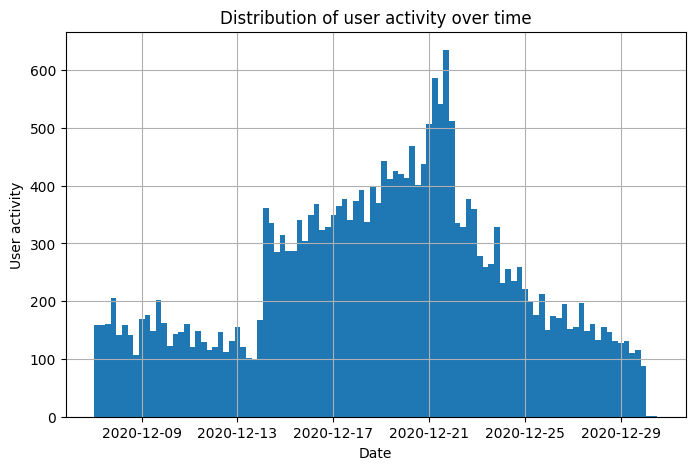

In [234]:
# Build a histogram of the distribution of user activity over time
spec_df['event_dt'].hist(bins=100, figsize=(8,5))
plt.title('Distribution of user activity over time')
plt.xlabel('Date')
plt.ylabel('User activity');

#### Comment
As you can see on the graph, the distribution of events is uneven. You can notice jumps in user activity on December 14, after which activity remains at a high level and on December 21 - the surge in activity lasted a day, after which the indicators go down and return to the initial indicators by December 29. The surge in user activity can be explained by the upcoming Catholic Christmas, when users buy gifts for their relatives and friends for the holiday.

In [235]:
spec_df.event_dt.describe()

count                   24698
unique                  16523
top       2020-12-09 19:01:05
freq                        6
first     2020-12-07 00:05:57
last      2020-12-30 12:42:57
Name: event_dt, dtype: object

In [236]:
# Check which of the marketing activities were carried out simultaneously with the test
marketing_events.query('start_dt > "2020-12-07" and finish_dt > "2020-12-30"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


#### Summary
"CIS New Year Gift Lottery" will not affect the study, since the event began on the last day of data collection (especially since the data was collected on 30.12.20 just before noon). The "Christmas&New Year Promo", which began on December 25, intersects with the test for five days. We will inform the customer about this circumstance.

In [237]:
# Let's shorten the investigated events to December 25 so that the data does not overlap 
# with Christmas&New Year Promo dates
spec_df_before_25_12 = spec_df.query('event_dt < "2020-12-25 00:00:00"')
spec_df_before_25_12.event_dt.describe()

count                   21370
unique                  14332
top       2020-12-09 19:01:05
freq                        6
first     2020-12-07 00:05:57
last      2020-12-24 23:58:32
Name: event_dt, dtype: object

## Evaluation of A/B testing results

Let's formulate hypotheses for the compared fractions:
    
    h₀ - There is no reason to consider the shares different.

    h₁ - There is a significant difference between the shares.

In [238]:
# Create a function where in the parameters we specify the dataset, the name of the event, the groups being compared and the alpha value
alpha = 0.05
def Ztest(data, event):
    
    # Count the number of completed events and unique users in groups
    gr1_event = data.query('group == "A" and @event in event_name').user_id.nunique()
    gr2_event = data.query('group == "B" and @event in event_name').user_id.nunique()
    gr1_users = data.query('group == "A"').user_id.nunique()
    gr2_users = data.query('group == "B"').user_id.nunique()
    
    # Calculate the shares in the groups and the difference between them
    p1 = gr1_event / gr1_users
    p2 = gr2_event / gr2_users
    difference = p1 - p2
    
    p_combined = (gr1_event + gr2_event) / (gr1_users + gr2_users)
    
    # Calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/gr1_users + 1/gr2_users))
    
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Event: {}'.format(event))
    print('p-value: ', round(p_value, 5))
    
    if p_value < alpha:
        print('Reject the null hypothesis: there is a significant difference between the shares')
    else:
        print('Not possible to reject the null hypothesis, there is no reason to consider the shares different')

In [239]:
events_list = ['product_page', 'product_cart', 'purchase']

In [240]:
# In the loop, let's run the event names for the prepared function
for event in events_list:
    Ztest(spec_df_before_25_12, event)
    print('-------------------------------------------------------------')
    print()

Event: product_page
p-value:  0.0
Reject the null hypothesis: there is a significant difference between the shares
-------------------------------------------------------------

Event: product_cart
p-value:  0.14535
Not possible to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------------------------

Event: purchase
p-value:  0.01759
Reject the null hypothesis: there is a significant difference between the shares
-------------------------------------------------------------



### Summary
Statistically significant differences between the control and test groups when comparing the "product_page" and "purchase" events are present, which cannot be said about the "product_cart" event, where there are no grounds to consider the shares different.

## General Conclusion and Recommendations

Summing up the results of the study, it is worth noting that it is not possible to conduct it in accordance with the terms of reference, since the data provided did not meet its requirements in many ways.
Thus: 
- The date of stopping the test according to TK: 2021-01-04, but the data was provided before 2020-12-30 12:42:57;
- Audience for TK: 15% of new users from the EU region, although in the data provided there were 13.7% of users from this region;

In addition to low-quality data, the following circumstances can be noted that negatively affect the results of the study:
- 1602 users participated simultaneously in recommender_system_test and interface_eu_test;
- There is a big difference between the number of participants in group A - 3824 and B - 2877;
- The coincidence of the dates of the test and the marketing event "Christmas&New Year Promo".

Judging by the results of the test with the available data, turning a blind eye to the above circumstances, the test group B showed worse results of conversions to events compared to group A: 
- "Go to the product page" is 10% lower; 
- "Basket page" - 5% lower; 
- "Making a purchase" - 4% lower.

When checking the statistical difference of the fractions by the z-criterion, it is established:
- "Go to the product page" - there is a difference between the shares; 
- "Basket page" - there is no reason to consider the shares different; 
- "Making a purchase" - there is a difference between the shares.

Considering the above and summing up the results of the study, there are sufficient grounds to consider A/B testing failed due to the presence of a large number of errors, which were mentioned earlier. To get better results,